In [52]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import time
import threading

from tqdm import tqdm
from string_generator import (
    create_strings_from_dict,
    create_strings_from_file,
    create_strings_from_file_random,
    create_strings_from_wikipedia,
    create_strings_randomly
)
from data_generator import FakeTextDataGenerator
from multiprocessing import Pool

ImportError: cannot import name 'create_strings_from_file_random'

In [53]:
def margins(margin):
    margins = margin.split(',')
    if len(margins) == 1:
        return [margins[0]] * 4
    return [int(m) for m in margins]


def load_dict(lang):
    """
    read dictionary and return all words in it
    :return:
    """
    lang_dict = []
    with open(os.path.join('dicts', lang + '.txt'),'r',encoding='utf8',errors='ignore') as d:
        lang_dict = d.readlines()
    return lang_dict


def load_files(lang):
    """
    read files and return file path to string_generator
    :return:
    """
    if lang == 'cn':
        return [os.path.join('files/cn', file) for file in os.listdir('files/cn')]
    else:
        return [os.path.join('files/latin', file) for file in os.listdir('files/latin')]


def load_fonts(lang):
    """
    read .ttf files and return the fonts
    P.S. only Truetype is allowed
    :return:
    """
    if lang == 'cn':
        return [os.path.join('fonts/cn', font) for font in os.listdir('fonts/cn')]
    else:
        return [os.path.join('fonts/latin', font) for font in os.listdir('fonts/latin')]

In [54]:
def gen_text_img(num, use_file, text_length, font_size, font_id, space_width, background, text_color,
                 blur, random_blur, distorsion, skew_angle, random_skew, thread_count):
    """

    :param num:
    :param use_file:
    :param text_length:
    :param font_size:
    :param font_id:
    :param space_width:
    :param background:
    :param text_color:
    :param blur:
    :param distorsion:
    :param skew_angle:
    :param thread_count:
    :return:
    """

    # Constant
    output_dir = 'out/'
    extension = 'jpg'
    distorsion_orientation = 0
    handwritten = False
    name_format = 0
    width = -1
    alignment = 1
    orientation = 0
    margins = (5, 5, 5, 5)
    fit = False

    language = 'cn'
    lang_dict = load_dict(language)

    fonts = load_fonts(language)

    if use_file:
        file_names = load_files(language)
        if text_length==-1:
            strings = create_strings_from_file_random(file_names, num)
        else:
            strings = create_strings_from_file(file_names, text_length, num)
    else:
        # to be implemented
        strings = create_strings_from_dict(text_length, num, lang_dict)

    p = Pool(thread_count)
    mutex = threading.Lock()
    result = []
    for _, img in p.imap_unordered(
            FakeTextDataGenerator.generate_from_tuple,
            zip(
                [i for i in range(0, num)],
                strings,
                [fonts[font_id]] * num if font_id else [fonts[random.randrange(0, len(fonts))] for _ in range(0, num)],
                [output_dir] * num,
                [font_size] * num if font_size else [random.randrange(28, 36) for _ in range(0, num)],
                [extension] * num,
                [skew_angle] * num,
                [random_skew] * num,
                [blur] * num,
                [random_blur] * num,
                [background] * num if background>=0 else [random.randint(0, 2) for _ in range(0, num)],
                [distorsion] * num if distorsion>=0 else [random.randint(0, 2) for _ in range(0, num)],
                [distorsion_orientation] * num,
                [handwritten] * num,
                [name_format] * num,
                [width] * num,
                [alignment] * num,
                [text_color] * num,
                [orientation] * num,
                [space_width] * num,
                [margins] * num,
                [fit] * num
            )
    ):
        if mutex.acquire(1):
            result.append((_, img))
            mutex.release()

    p.terminate()
    final_image = np.concatenate([img for _, img in result], axis=1)
    df = pd.concat([meta for meta, _ in result])
    df = df.reset_index(drop=True)

    return df, final_image

In [51]:
num = 10
use_file = 1
text_length = -1
font_size = 0
font_id = 1
space_width = 1
text_color = '#282828'
thread_count = 8

# skew & blur 
"""
    If random_xxx is set True, the following variable decides the range.
    If random_xxx is set True, the following variable decides the constant.
    The variable should be set in NON-NEGATIVE INTEGER.
    skew_angle is better not be greater than 3.
    blur is better not be greater than 2.   
"""
random_skew = True
skew_angle = 1
random_blur = True
blur = 0

#distorsion & background 
"""
    distorsion: 0: None (Default), 1: Sine wave, 2: Cosine wave, -1: Random
    background: 0: Gaussian Noise, 1: Plain white, 2: Quasicrystal, -1:Random
"""
distorsion = -1
background = -1

start_time = time.time()
df, target = gen_text_img(num, use_file, text_length, font_size, font_id, space_width, background, text_color,
                          blur,random_blur, distorsion, skew_angle, random_skew, thread_count)
cv2.imwrite(os.path.join('out/' + 'target.jpg'), target)
end_time = time.time()
print('time for synthesize 1000 image:', end_time - start_time)
print(df)


NameError: name 'create_strings_from_file_random' is not defined

In [55]:
display(df.head(5))
print(target.shape)

,index,text,img_shape,font_size,font_id,skew_angle,distorsion_type,blur,background_type
0,4,里三层外三层地包裹住,188,30,FZKaiTi,-1,None,0,Plain white
1,1,涯给幸存者留下的标记,188,30,FZKaiTi,-1,None,0,Guassian
2,5,，封存在箱子里；惟恐,146,29,FZKaiTi,-1,Cosine wave,0,Plain white
3,6,它们跟那些生灵一般，,151,32,FZKaiTi,-1,Cosine wave,0,Plain white
4,8,直至一个晴朗得要命的,150,29,FZKaiTi,-1,Cosine wave,0,Plain white


(32, 1657, 3)


In [11]:
# df['text'].map(len).sum()
df['img_shape'].astype(np.int).sum()

1612

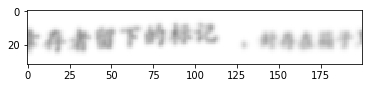

In [12]:
import matplotlib.pyplot as plt
plt.imshow(target[:,208:(200+208),:])

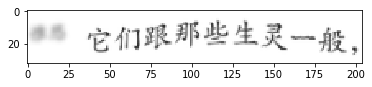

In [13]:
plt.imshow(target[:,(217+208):(217+208+204),:])

In [9]:
import random
print(random.randint(-3,3))

-2
